# 2023 Immune dataset H3K36me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps an active gene (defined varying RPKM from 0 to 2)
and compared methods based on sensitivity, precision and F-score.

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os

In [ ]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

## Load hg38 gtf file

In [ ]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

In [ ]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

In [ ]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

## Annotatate RNA-seq tables with positions

In [273]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

BCell /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv


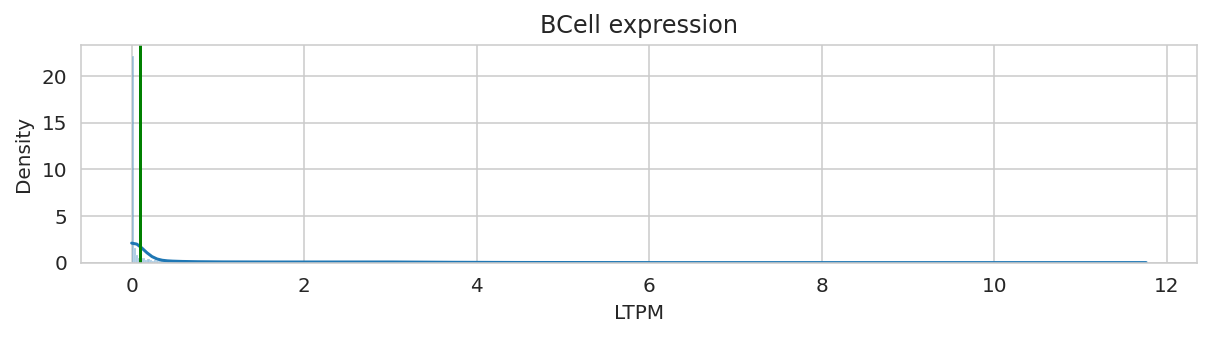

Total genes with positions 58387
Genes logTPM > 0.1 20769
Merging overlapping regions 20769
Reduced to 15121
Saved expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1.bed
TCell /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv


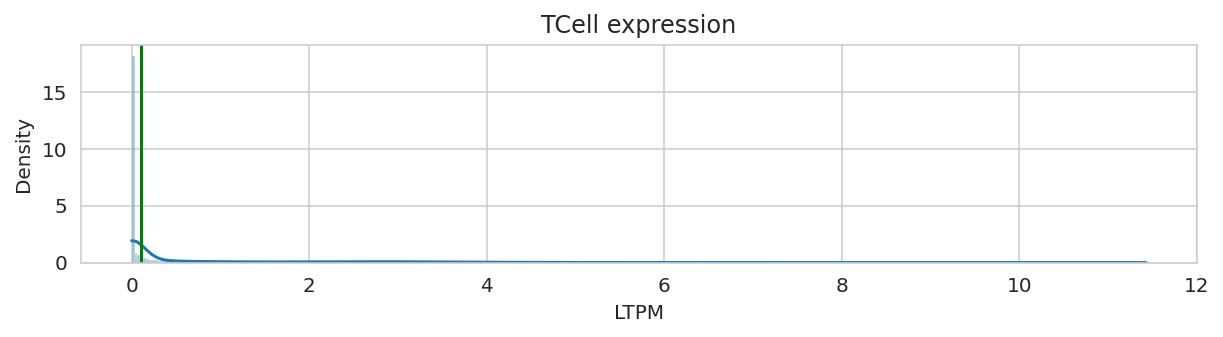

Total genes with positions 58387
Genes logTPM > 0.1 21110
Merging overlapping regions 21110
Reduced to 15303
Saved expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1.bed
Monocyte /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv


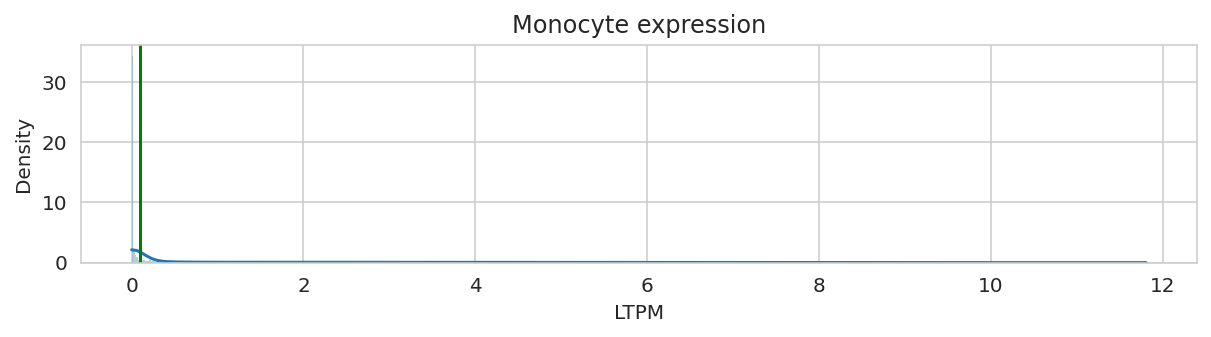

Total genes with positions 58387
Genes logTPM > 0.1 18584
Merging overlapping regions 18584
Reduced to 13519
Saved expressed genes fom Monocyte to /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO_tpm0.1.bed


In [274]:
import re

PATH = os.path.expanduser('~/data/2023_Immune')

EXPRESSION_TSV = {
    'BCell': PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    'TCell': PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    'Monocyte': PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}
THRESHOLD = 0.1

EXPRESSION_BED = {}

for cell, path in EXPRESSION_TSV.items():
    print(cell, path)
    t = pd.read_csv(path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # Plot expression
    plt.figure(figsize=(10, 2))
    ax = plt.axes()
    g_results = sns.histplot(data=t, x='LTPM', ax=ax,
                             stat='density',
                             kde=True, alpha=0.4)
    ax.axvline(x=THRESHOLD, color='green')
    ax.title.set_text(f'{cell} expression')
    plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]

    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')

    # Plot expressed genes lengths
    # plt.figure(figsize=(4, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(x=full_df['end']-full_df['start'], ax=ax,
    #                          stat='density',
    #                          bins=100, log_scale=True, kde=True, alpha=0.4)
    # g_results.set(xscale='log')
    # ax.title.set_text(f'{cell} genes lengths')
    # plt.show()

    expr_path = path.replace('.tsv', f'_tpm{THRESHOLD}.bed')
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_BED[cell] = expr_path


## Load peaks

In [275]:
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K36me3']

def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (f, mod, cell, fdr, ps, avls)
    return df_fdr

In [276]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['file'] = [f'{PATH}/macs2/{f}' for f in df_fdr_macs2['file']]
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['file'] = [f'{PATH}/macs2/{f}' for f in df_fdr_macs2broad['file']]
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
df_fdr_sicer['file'] = [f'{PATH}/sicer/{f}' for f in df_fdr_sicer['file']]
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['file'] = [f'{PATH}/span/{f}' for f in df_fdr_span['file']]
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/88 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/88 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/102 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/14 [00:00<?, ?it/s]

SPAN 3


,file,modification,cell,fdr,peaks,avlength,tool
2,/home/jetbrains/data/2023_Immune/sicer/Monocyt...,H3K36me3,Monocyte,0.01,31796,9650.943641,SICER
1,/home/jetbrains/data/2023_Immune/sicer/TCell_H...,H3K36me3,TCell,0.01,32491,10544.369487,SICER
1,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K36me3,BCell,0.1,152502,1426.661808,MACS2 broad
2,/home/jetbrains/data/2023_Immune/span/Monocyte...,H3K36me3,Monocyte,0.05,28390,13512.964882,SPAN
0,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,H3K36me3,Monocyte,0.1,105833,1881.369601,MACS2 broad


In [277]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'Genes']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

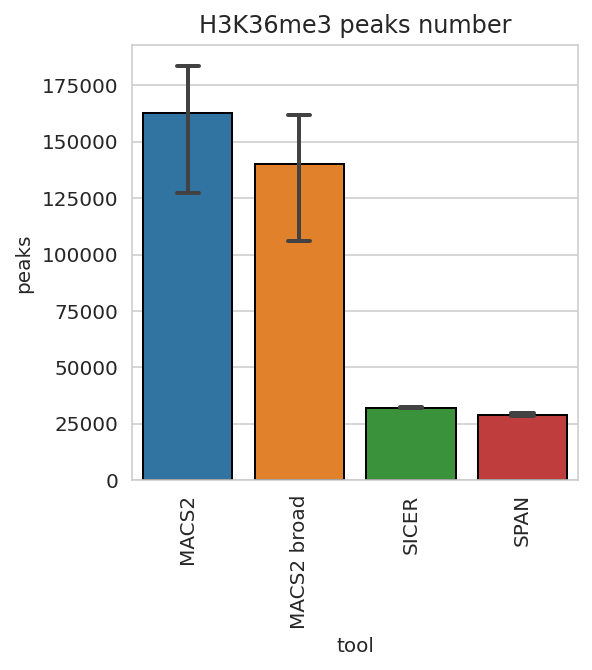

In [278]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K36me3 peaks number')
plt.show()

## Expressed genes vs peaks lengths

In [279]:
ts = []
for cell in IMMUNE_CELLS:
    t = pd.read_csv(EXPRESSION_BED[cell], sep='\t',
                    names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM'])
    ts.append(pd.DataFrame(dict(name=['Genes'] * len(t), length=t['end']-t['start'])))
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(name=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,name,length
132331,SICER,7399
106034,SICER,7799
160947,SPAN,8751
26706,Genes,194641
56969,MACS2,508
162025,SPAN,51947
151887,SPAN,5162
31301,Genes,6782
114365,SICER,3999
12208,Genes,98669


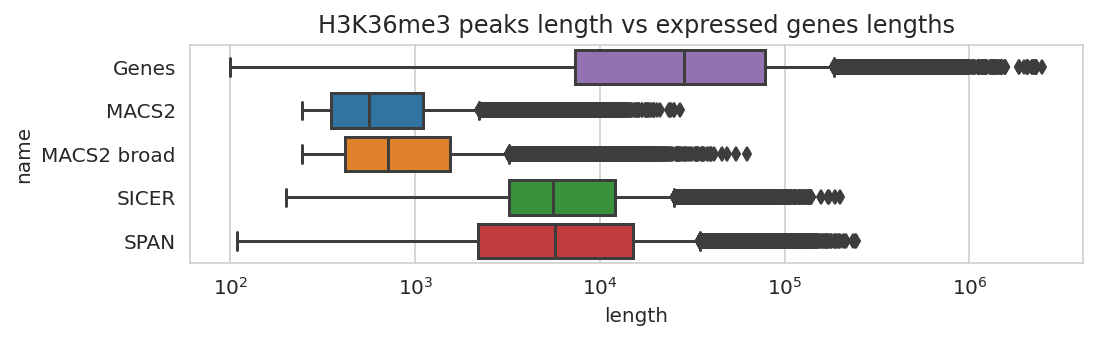

In [280]:
plt.figure(figsize=(8, 2))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='length', y='name', ax=ax, palette=TOOLS_PALETTE)
g_results.set(xscale='log')
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

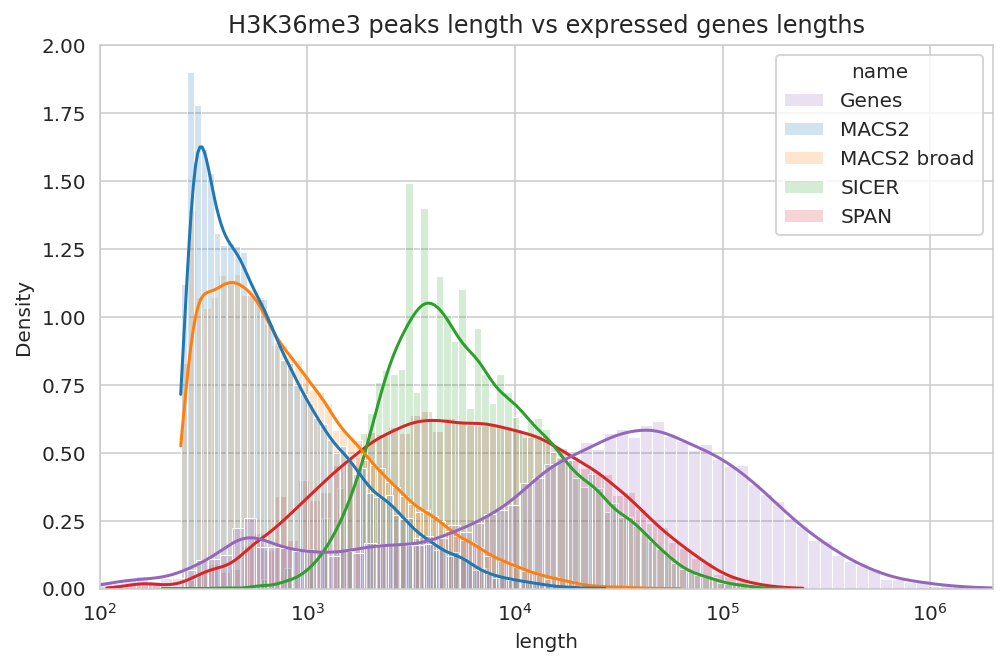

In [281]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 2)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

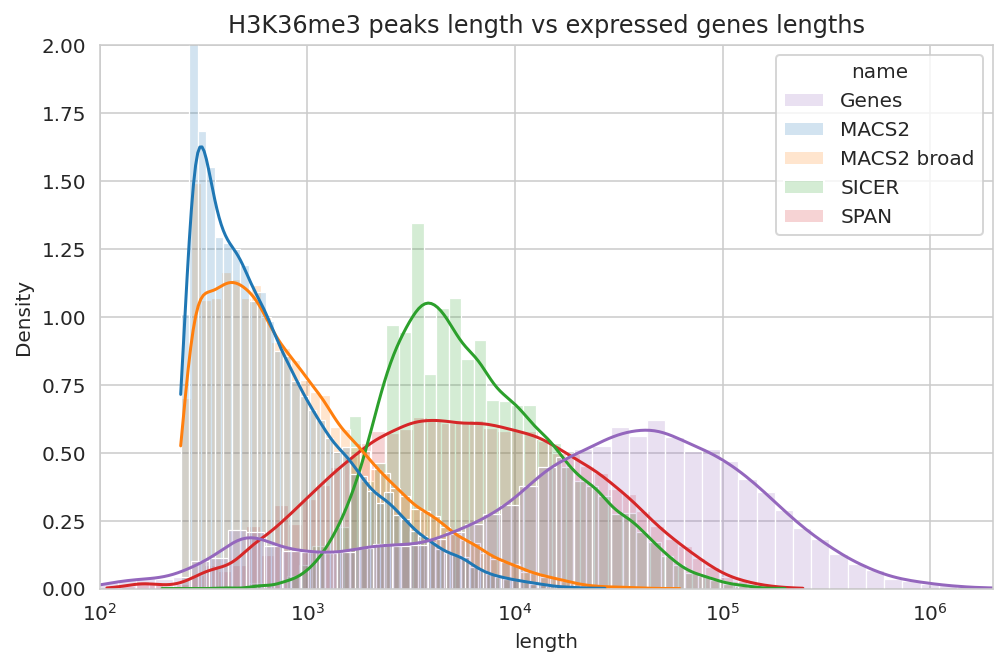

In [282]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 2)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

In [283]:
# Randomly tweak SICER lengths for visualization purposes
tsicer = t['name'] == 'SICER'
t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

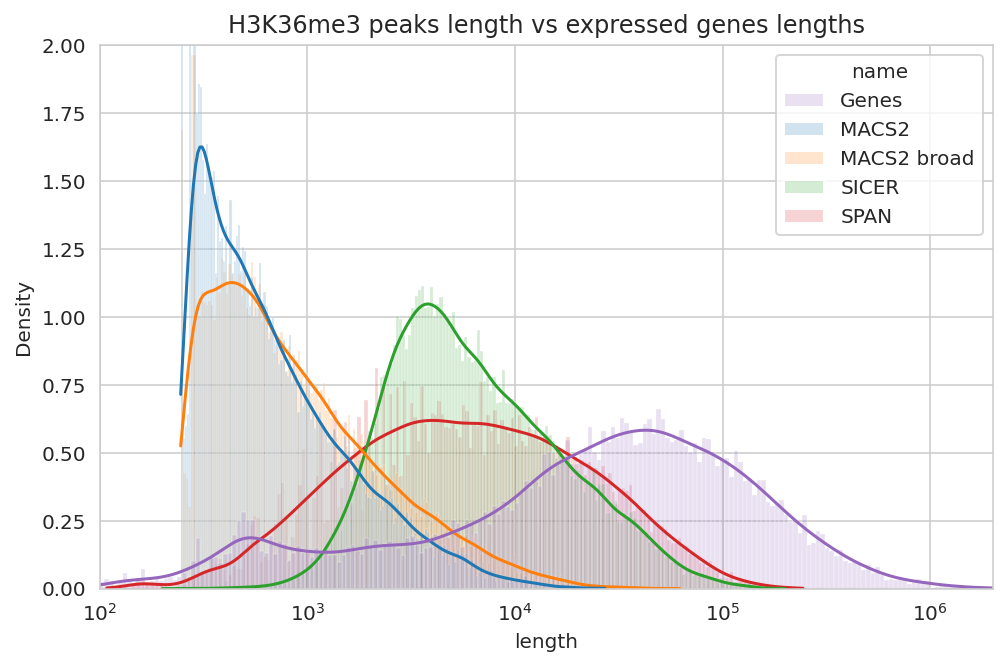

In [284]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=200, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 2)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

## Overlap H3K36me3 vs expressed genes

In [285]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len', 'genes', 'genes_len',
             'peaks_overlap', 'peaks_overlap_len', 'genes_overlap', 'genes_overlap_len'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u > {tf}
        genes_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {expr_file} -wo > {tf}
        peaks_overlap_len = genes_overlap_len = int(last_col(tf).sum())

        bench_df.loc[len(bench_df)] = (c, tool, peaks, peaks_len, genes, genes_len,
                                       peaks_overlap, peaks_overlap_len, genes_overlap, genes_overlap_len)
# bench_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


In [286]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['genes_overlap'], bench_df['genes'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['genes_overlap_len'], bench_df['genes_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['genes_len'], bench_df['genes_overlap_len'])
]

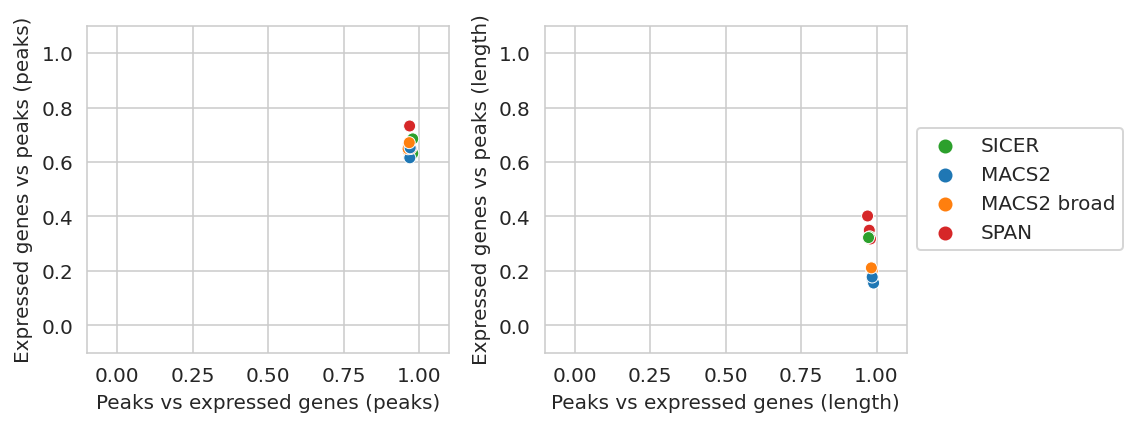

In [319]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs expressed genes (peaks)')
g_results.axes.set_ylabel('Expressed genes vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs expressed genes (length)')
g_results.axes.set_ylabel('Expressed genes vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [289]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
del ts

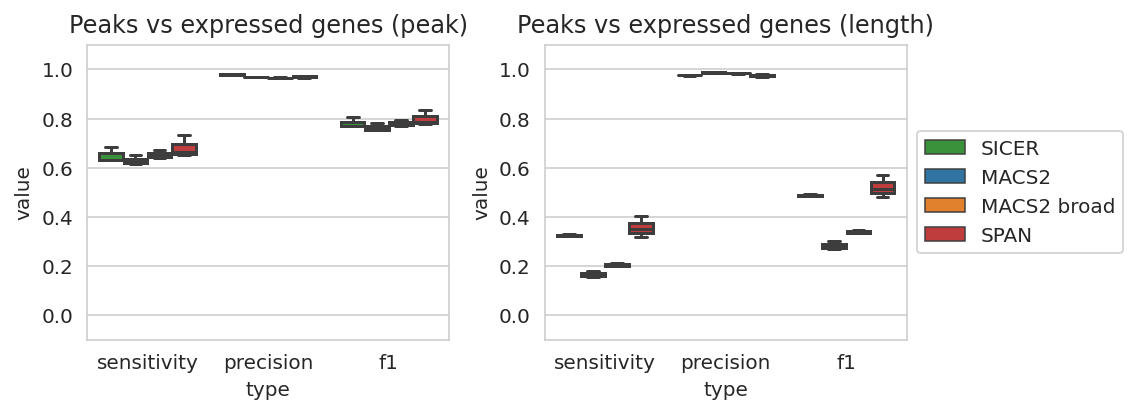

In [290]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name', palette=TOOLS_PALETTE, ax=axs[i])
    ax = g_results.axes
    ax.set_title(f'Peaks vs expressed genes ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

## Overlap H3K36me3 diff vs expressed genes

In [291]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len',
             'genes', 'genes_len',
             'peaks_overlap', 'peaks_overlap_len',
             'genes_overlap', 'genes_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c in tqdm(IMMUNE_CELLS):
    if (c) not in EXPRESSION_BED:
        continue
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            !bedtools intersect -a {tf} -b {expr_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            !bedtools intersect -b {tf} -a {expr_file} -wa -u > {tf2}
            genes_overlap = lines(tf2)
            !bedtools intersect -a {tf} -b {expr_file} -wo > {tf2}
            peaks_overlap_len = genes_overlap_len = int(last_col(tf2).sum())

            diff_bench_df.loc[len(diff_bench_df)] = \
                (c, name,
                 peaks, peaks_len,
                 genes, genes_len,
                 peaks_overlap, peaks_overlap_len,
                 genes_overlap, genes_overlap_len)

display(diff_bench_df.sample())

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


,cell,name,peaks,peaks_len,genes,genes_len,peaks_overlap,peaks_overlap_len,genes_overlap,genes_overlap_len
14,Monocyte,SPAN - MACS2 broad,9956,27561624,13519,926772870,9383,26394612,3511,26394612


In [292]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap'], diff_bench_df['genes'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])]
diff_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap_len'], diff_bench_df['genes_len'])]
diff_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                           for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])]

diff_bench_df['jaccard'] = [ d(o, p + g -o)
                             for p, g, o in zip(diff_bench_df['peaks_len'], diff_bench_df['genes_len'], diff_bench_df['genes_overlap_len'])
                             ]

In [293]:
full_bench_df = pd.concat([bench_df,diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

,cell,name,peaks,peaks_len,genes,genes_len,peaks_overlap,peaks_overlap_len,genes_overlap,genes_overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard
2,BCell,MACS2 broad,152502,217568779,15121,1070202389,147125,214292955,9685,214292955,0.964741,0.640500,7.698741e-01,0.984944,0.200236,3.328122e-01,0.199625
17,BCell,SICER - SPAN,186,701014,15121,1070202389,175,671892,164,671892,0.940860,0.010846,2.144448e-02,0.958457,0.000628,1.254814e-03,0.000628
15,BCell,MACS2 broad - SPAN,1044,349092,15121,1070202389,892,302155,747,302155,0.854406,0.049401,9.340249e-02,0.865545,0.000282,5.644850e-04,0.000282
25,Monocyte,MACS2 - SPAN,0,0,13519,926772870,0,0,0,0,0.000000,0.000000,1.000000e-10,0.000000,0.000000,1.000000e-10,0.000000
29,Monocyte,SICER - SPAN,0,0,13519,926772870,0,0,0,0,0.000000,0.000000,1.000000e-10,0.000000,0.000000,1.000000e-10,0.000000


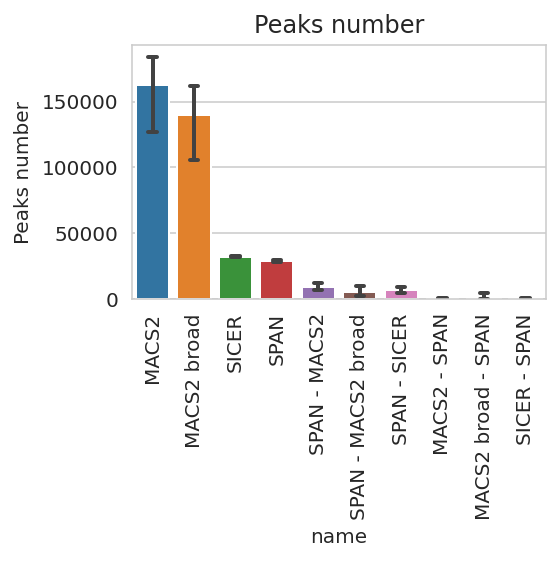

In [294]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

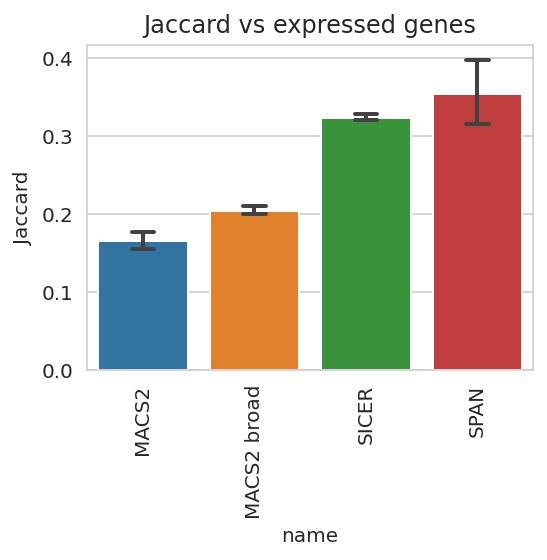

In [295]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [296]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

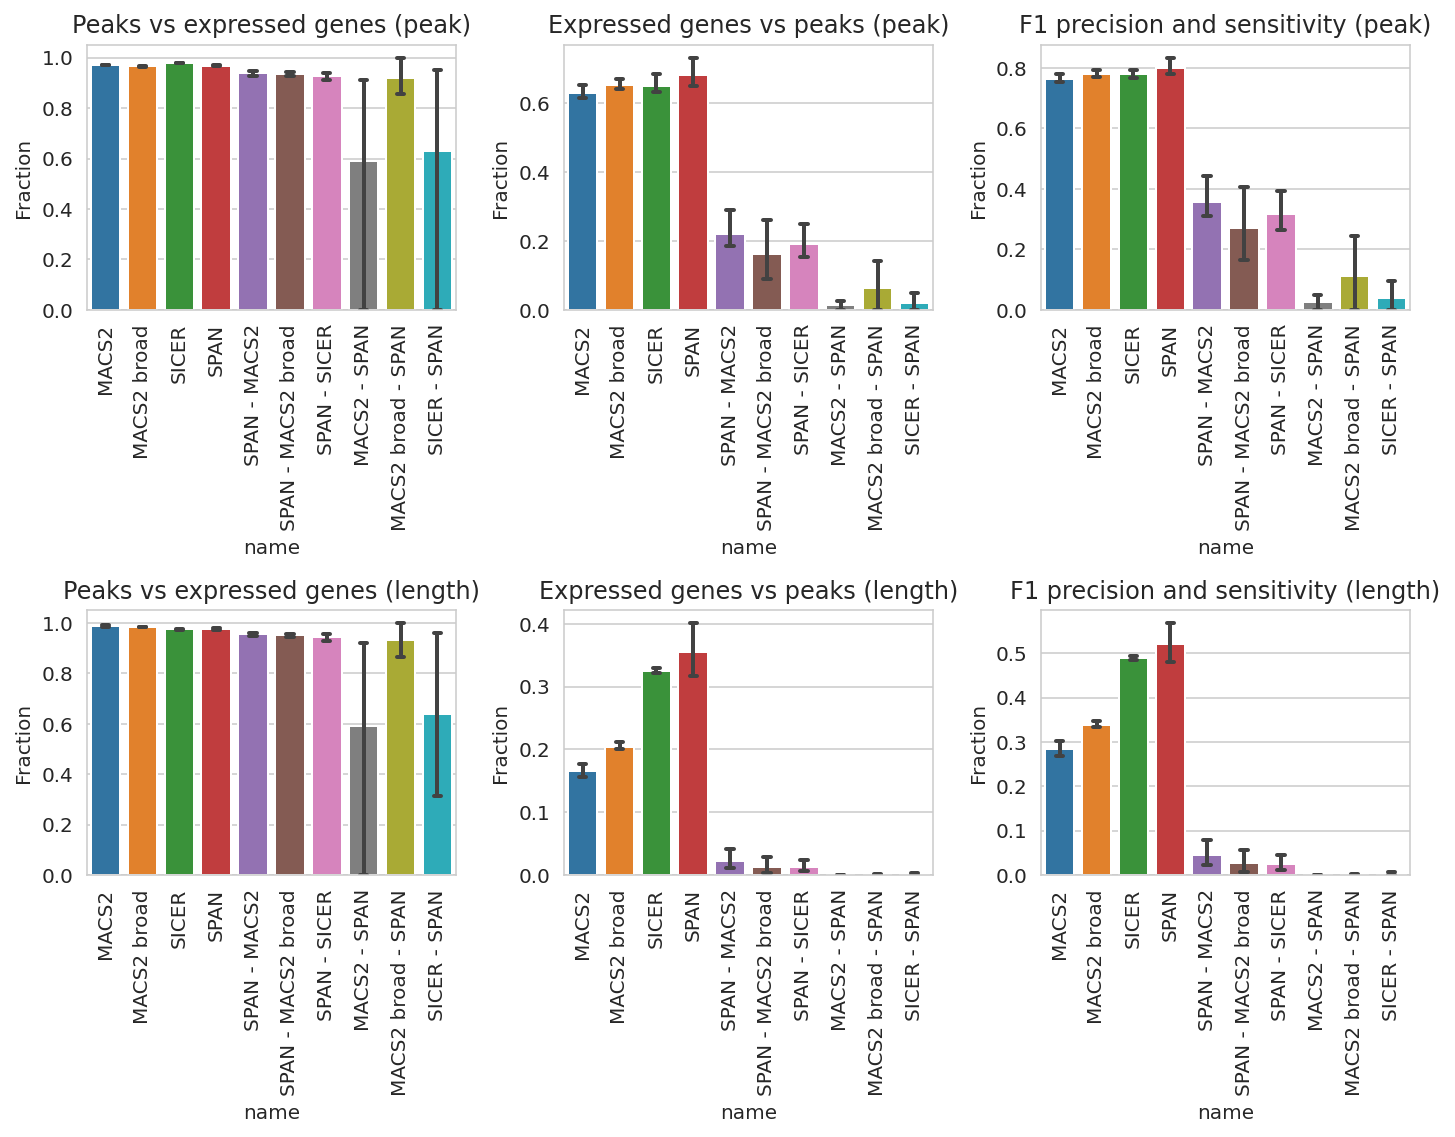

In [297]:
plt.figure(figsize=(10, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peak', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks vs expressed genes ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'Expressed genes vs peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

## Venn diagram

In [298]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

def num_format(x, engineer):
    if x <= 0:
        return ''
    elif engineer:
        return f'{x:.0e}'
    else:
        return str(x)

num_format(1.3e10, True)

VENN2_SUBSETS = ['1', '2', '1,2']
VENN2_LABELS = ['10', '01', '11']

def venn2_overlap(ax, peaks1, peaks2, overlap12, overlap21, name1, name2,
                  show_numbers=True, engineer=False, add_proportion=False,
                  set_font=15, subset_font=10):
    max_peaks = max(peaks1, peaks2)
    max_overlap = max(overlap12, overlap21)
    # Tweak subsets to avoid empty areas
    if show_numbers:
        subsets = (
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks1 - overlap12)) if peaks1 > overlap12 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks2 - overlap21)) if peaks2 > overlap21 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, max_overlap))
        )
    else:
        subsets = (peaks1 - overlap12, peaks2 - overlap21, max_overlap)
    v = venn2(subsets=subsets, set_labels=(name1, name2), alpha=0.3, ax=ax)
    # venn2_circles(subsets=subsets, color='grey', ax=ax)

    if show_numbers:
        v.get_label_by_id('10').set_text(num_format(peaks1 - overlap12, engineer))
        v.get_label_by_id('01').set_text(num_format(peaks2 - overlap21, engineer))
        if add_proportion:
            if overlap12 != 0 and overlap21 != 0:
                if overlap12 > overlap21:
                    prop = f'{overlap12 / overlap21:.1f} : 1'
                else:
                    prop = f'1 : {overlap21 / overlap12:.1f}'
                prop = prop.replace('.0', '')  # Cosmetics
            else:
                prop = ''
            v.get_label_by_id('11').set_text(f'{overlap12} : {overlap21}\n{prop}')
        else:
            v.get_label_by_id('11').set_text(num_format(max_overlap, engineer))
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    if not show_numbers:
        for l in VENN2_LABELS:
            label = v.get_label_by_id(l)
            if label is not None:
                label.set_text('')

VENN3_SUBSETS = ['1', '2', '1,2', '3', '1,3', '2,3', '1,2,3']
VENN3_LABELS = ['100', '010', '110', '001', '101', '011', '111']

def venn3_overlap(ax, v1, v2, v12, v3, v13, v23, v123, name1, name2, name3,
                  show_numbers=True, engineer=False,
                  set_font=15, subset_font=10):
    subsets=(v1, v2, v12, v3, v13, v23, v123)
    t = {l: s for l, s in zip(VENN3_LABELS, subsets)}
    v = venn3(subsets=subsets,
              set_labels=(name1, name2, name3),
              alpha=0.3,
              ax=ax)
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    for l in VENN3_LABELS:
        label = v.get_label_by_id(l)
        if label is not None:
            if not show_numbers:
                label.set_text('')
            else:
                label.set_text(num_format(t[l], engineer))

  0%|          | 0/1 [00:00<?, ?it/s]

BCell
Venn diagrams of SPAN vs other tools (peaks)


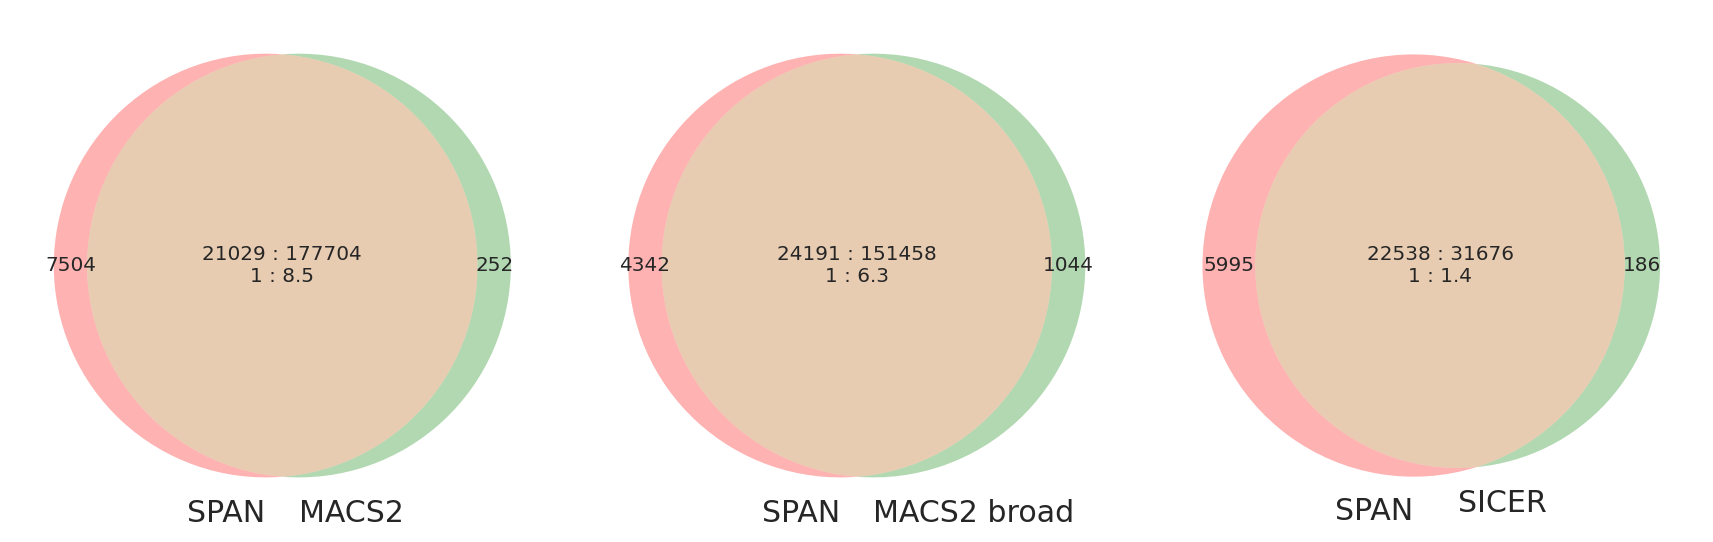

Venn diagram of SPAN vs other tools and expressed genes (ranges)


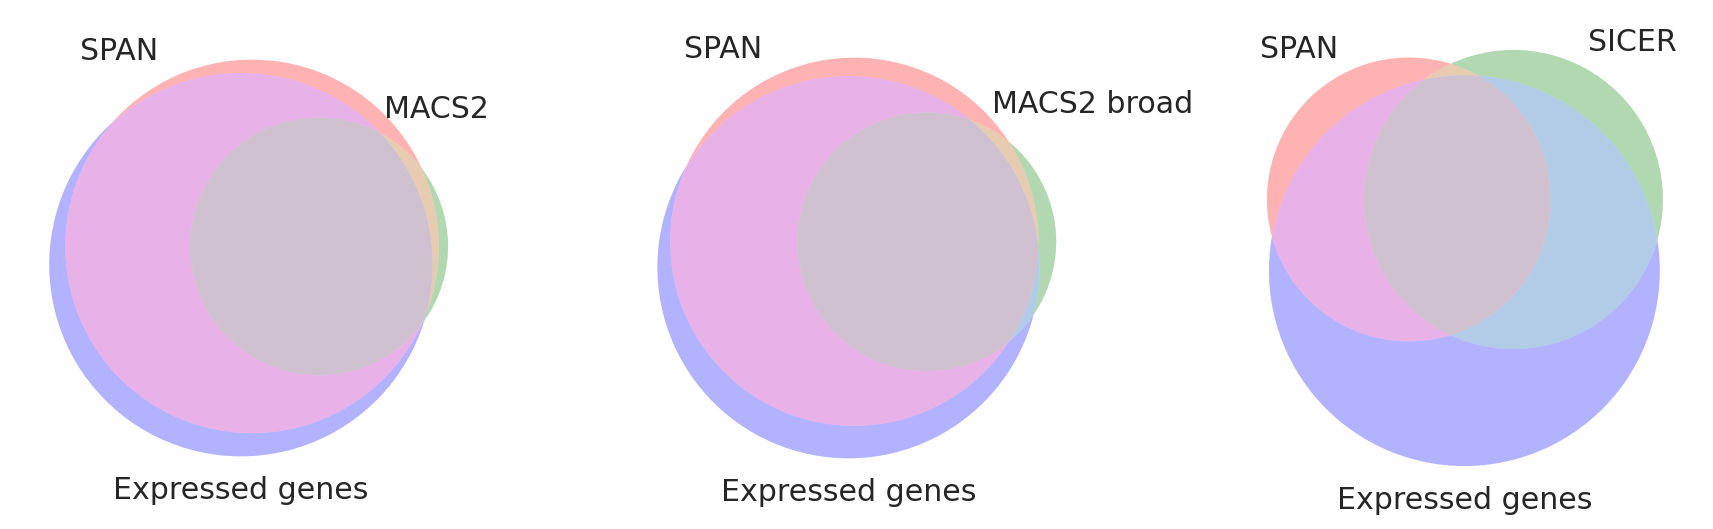

Venn diagram of SPAN vs other tools and expressed genes (length)


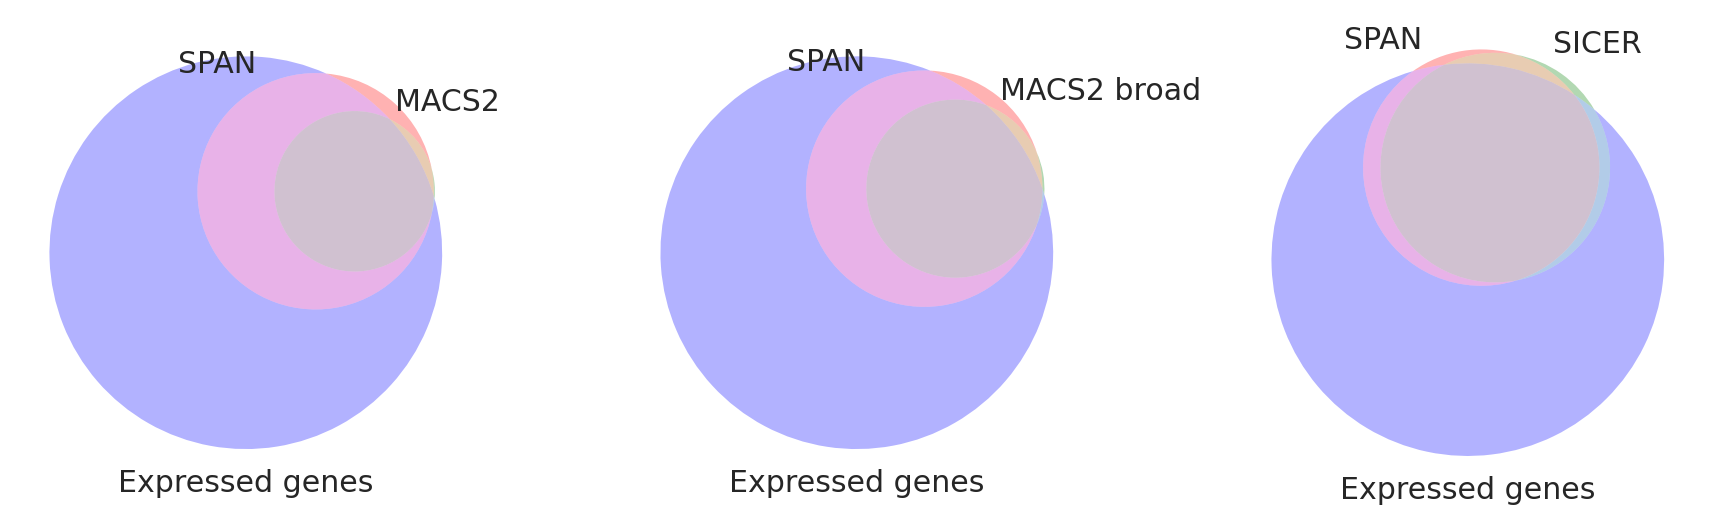

In [299]:
other_tools = list(sorted(filter(lambda t: t != 'SPAN', bench_df['name'].unique())))

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c in tqdm(['BCell']):
    if (c) not in EXPRESSION_BED:
        continue
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[(c)])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    span_peaks = lines(span_file)
    span_len = int(bedl(span_file).sum())
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())

    print('Venn diagrams of SPAN vs other tools (peaks)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {span_file} -b {peaks_file} -wa -u > {tf}
        span_overlap = lines(tf)
        !bedtools intersect -b {span_file} -a {peaks_file} -wa -u > {tf}
        other_overlap = lines(tf)
        venn2_overlap(axs[i], span_peaks, peaks_number, span_overlap, other_overlap, 'SPAN', tool,
                      show_numbers=True, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print('Venn diagram of SPAN vs other tools and expressed genes (ranges)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {expr_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[(t['overlap_details'] == o).sum() for o in VENN3_SUBSETS],
                      'SPAN', tool, 'Expressed genes',
                      show_numbers=False, engineer=True)
    plt.tight_layout()
    plt.show()

    print('Venn diagram of SPAN vs other tools and expressed genes (length)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {expr_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[
            (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
            for o in VENN3_SUBSETS
        ], 'SPAN', tool, 'Expressed genes', show_numbers=False, engineer=True)

    plt.tight_layout()
    plt.show()

## Compare genes expression overlapping peaks

In [267]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

ts = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])

        for overlap, overlap_param in [
            ('1bp', ''),
            ('50%', ' -f 0.5 '),
        ]:
            !bedtools intersect -a {expr_file} -b {peaks_file} -wa -u {overlap_param} > {tf}
            tf_expression = pd.read_csv(tf, sep='\t',
                                        names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'expression']
                                        )[['expression']].copy()
            tf_expression['name'] = tool
            tf_expression['overlap'] = overlap
            ts.append(tf_expression)

peaks_expression = pd.concat(ts).reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


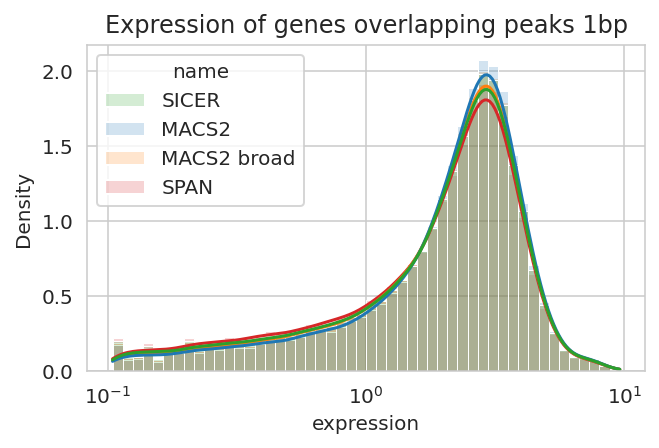

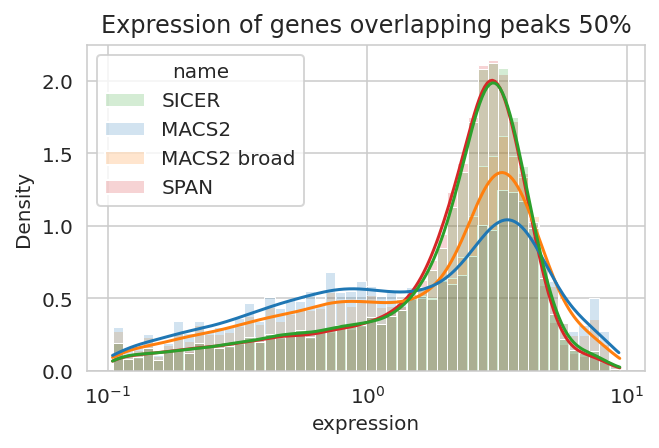

In [268]:
for overlap in peaks_expression['overlap'].unique():
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    g_results = sns.histplot(data=peaks_expression[peaks_expression['overlap']==overlap], x='expression', hue='name', ax=ax,
                             bins=50, stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE)
    g_results.set(xscale='log')
    ax.title.set_text(f'Expression of genes overlapping peaks {overlap}')
    plt.show()

## Compare ratio of peaks vs genes

In [316]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

ratio_df = pd.DataFrame(columns=['cell', 'tool', 'genes', 'peaks'], dtype=object)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = sorted_file(EXPRESSION_BED[c])
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])

        # Expr file: names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'tpm', 'logTPM']
        !bedtools intersect -a {expr_file} -b {peaks_file} -wa -wb > {tf}
        try:
            tf_expression = pd.read_csv(tf, sep='\t', header=None)
            genes = len(tf_expression.groupby([0, 1, 2]).count())
            peaks = len(tf_expression.groupby([7, 8, 9]).count())
            ratio_df.loc[len(ratio_df)] = (c, tool, genes, peaks)
        except:
            pass
ratio_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


,cell,tool,genes,peaks
0,BCell,SICER,9568,31183
1,BCell,MACS2,9393,172577
2,BCell,MACS2 broad,9685,147125
3,BCell,SPAN,10005,27547
4,TCell,SICER,9664,31827
5,TCell,MACS2,9416,178040
6,TCell,MACS2 broad,9923,155914
7,TCell,SPAN,9940,28855
8,Monocyte,SICER,9257,31140
9,Monocyte,MACS2,8814,123404


In [314]:
ratio_df['peaks_to_genes'] = ratio_df['peaks'] / ratio_df['genes']
ratio_df.sort_values(by=['tool'], inplace=True)

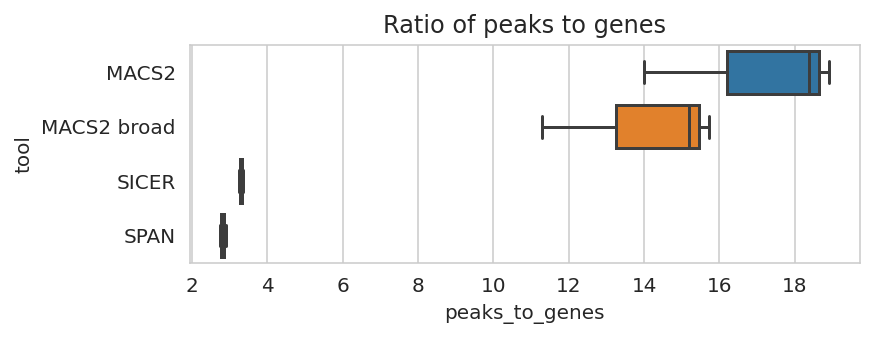

In [315]:
plt.figure(figsize=(6, 2))
ax = plt.axes()
g_results = sns.boxplot(data=ratio_df, x='peaks_to_genes', y='tool', ax=ax, palette=TOOLS_PALETTE)
ax.title.set_text('Ratio of peaks to genes')
plt.show()

# H3K36me3 TPM benchmark

In [300]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
expr_file = tempfile.mktemp()

benchmark_tpm_df = pd.DataFrame(
    columns=['cell', 'tpm', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'overlap', 'tool'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = pd.read_csv(EXPRESSION_TSV[c], sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)

    for tpm in np.linspace(0, 0.5, 6):
        print('Processing TMP', tpm)
        full_df[full_df['LTPM'] > tpm].to_csv(expr_file, sep='\t', index=False, header=None)
        expr_file = sorted_file(expr_file)
        genes = lines(expr_file)
        for tool in set(df_fdr_peaks['tool']):
            t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                             (df_fdr_peaks['modification'] == 'H3K36me3') &
                             (df_fdr_peaks['cell'] == c)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            peaks = lines(peaks_file)
            for overlap, overlap_param in [
                ('1bp', ''),
                ('50%', ' -f 0.5 ')
            ]:
                !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u {overlap_param} > {tf}
                peaks_overlap = lines(tf)
                !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u {overlap_param} > {tf}
                genes_overlap = lines(tf)
                benchmark_tpm_df.loc[len(benchmark_tpm_df)] = \
                    (c, tpm, genes, peaks_file, peaks, peaks_overlap, genes_overlap, overlap, tool)

benchmark_tpm_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
TCell
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
Monocyte
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5


,cell,tpm,genes,peaks_file,peaks,pg,gp,overlap,tool
0,BCell,0.0,21690,/tmp/tmpasuemu51,31862,31269,10751,1bp,SICER
1,BCell,0.0,21690,/tmp/tmpasuemu51,31862,30806,4645,50%,SICER
2,BCell,0.0,21690,/tmp/tmpkyg736z5,177956,173225,10402,1bp,MACS2
3,BCell,0.0,21690,/tmp/tmpkyg736z5,177956,172328,736,50%,MACS2
4,BCell,0.0,21690,/tmp/tmphfwc_yno,152502,147805,10797,1bp,MACS2 broad
...,...,...,...,...,...,...,...,...,...
139,Monocyte,0.5,10587,/tmp/tmp53fcbr_3,127115,119671,586,50%,MACS2
140,Monocyte,0.5,10587,/tmp/tmpxxn77otb,105833,99241,8744,1bp,MACS2 broad
141,Monocyte,0.5,10587,/tmp/tmpxxn77otb,105833,98558,988,50%,MACS2 broad
142,Monocyte,0.5,10587,/tmp/tmp_6p47tl0,28390,25725,9231,1bp,SPAN


In [301]:
benchmark_tpm_df['p'] = (benchmark_tpm_df['pg'] + benchmark_tpm_df['gp']) / 2
benchmark_tpm_df['precision'] = [d(x, y) for x, y in zip(benchmark_tpm_df['pg'], benchmark_tpm_df['peaks'])]
benchmark_tpm_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_tpm_df['gp'], benchmark_tpm_df['genes'])]
benchmark_tpm_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_tpm_df['sensitivity'], benchmark_tpm_df['precision'])]
benchmark_tpm_df

,cell,tpm,genes,peaks_file,peaks,pg,gp,overlap,tool,p,precision,sensitivity,f1
0,BCell,0.0,21690,/tmp/tmpasuemu51,31862,31269,10751,1bp,SICER,21010.0,0.981388,0.495666,0.658664
1,BCell,0.0,21690,/tmp/tmpasuemu51,31862,30806,4645,50%,SICER,17725.5,0.966857,0.214154,0.350642
2,BCell,0.0,21690,/tmp/tmpkyg736z5,177956,173225,10402,1bp,MACS2,91813.5,0.973415,0.479576,0.642573
3,BCell,0.0,21690,/tmp/tmpkyg736z5,177956,172328,736,50%,MACS2,86532.0,0.968374,0.033933,0.065568
4,BCell,0.0,21690,/tmp/tmphfwc_yno,152502,147805,10797,1bp,MACS2 broad,79301.0,0.969200,0.497787,0.657750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Monocyte,0.5,10587,/tmp/tmp53fcbr_3,127115,119671,586,50%,MACS2,60128.5,0.941439,0.055351,0.104555
140,Monocyte,0.5,10587,/tmp/tmpxxn77otb,105833,99241,8744,1bp,MACS2 broad,53992.5,0.937713,0.825919,0.878273
141,Monocyte,0.5,10587,/tmp/tmpxxn77otb,105833,98558,988,50%,MACS2 broad,49773.0,0.931260,0.093322,0.169644
142,Monocyte,0.5,10587,/tmp/tmp_6p47tl0,28390,25725,9231,1bp,SPAN,17478.0,0.906129,0.871918,0.888695


In [302]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))

PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [303]:
import plotly.graph_objects as go

def plot_tpm(benchmark_tpm_df):
    tools_legend_shown = set()
    fig = go.Figure()
    for overlap in benchmark_tpm_df['overlap'].unique():
        marker = 'square' if overlap == '1bp' else  'circle' if overlap == '50%' else 'diamond'
        for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_tpm_df[(benchmark_tpm_df['cell'] == c) &
                               (benchmark_tpm_df['overlap'] == overlap) &
                               (benchmark_tpm_df['tool'] == t)]
            if len(dft) == 0:
                continue
            fig.add_trace(go.Scatter(
                x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
                hovertext=dft['tpm'].astype(str) + ' ' + t, marker_symbol=[marker] * len(dft),
                showlegend=t not in tools_legend_shown,
                marker_color=PLOTLY_TOOLS_PALETTE[t],
                opacity=0.3
            ))
            tools_legend_shown.add(t)


    for overlap in set(benchmark_tpm_df['overlap']):
        marker = 'square' if overlap == '1bp' else  'circle' if overlap == '50%' else 'diamond'
        for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_tpm_df[(benchmark_tpm_df['cell'] == c) &
                                   (benchmark_tpm_df['overlap'] == overlap) &
                                   (benchmark_tpm_df['tool'] == t) &
                                   (benchmark_tpm_df['tpm'] == 0.1)]
            if len(dft) == 0:
                continue
            fig.add_trace(
                go.Scatter(
                    mode='markers',
                    x=dft["precision"], y=dft["sensitivity"],
                    name=t,
                    marker=dict(color='white', size=10, line=dict(width=1), symbol=marker),
                    showlegend=False,
                    hovertext=dft['tpm'].astype(str) + ' ' + t
                )
            )

    # fig.update_xaxes(range=[-0.1, 1.1], title='Peaks overlapping active genes (precision)')
    # fig.update_yaxes(range=[-0.1, 1.1], title='Active genes overlapping peaks (sensitivity)')
    fig.update_xaxes(title='Peaks overlapping active genes (precision)')
    fig.update_yaxes(title='Active genes overlapping peaks (sensitivity)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600,)
    fig.show()


In [304]:
plot_tpm(benchmark_tpm_df[benchmark_tpm_df['overlap'] == '1bp'])

In [305]:
plot_tpm(benchmark_tpm_df[benchmark_tpm_df['overlap'] == '50%'])

# Fraction of reads in peaks

In [ ]:
IMMUNE_HG38_PATH_BW = PATH + '/bw'

def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [ ]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K36me3')
bws_df.sample(3)

In [ ]:
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
bws_control_df.sample(3)

In [ ]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

In [ ]:
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K36me3') &
                   (bws_df['cell'] == c)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[bws_control_df['cell'] == c]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]))
        frip_df.loc[len(frip_df)] = (c, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

In [ ]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / (z / 1e3)) / (y / 1e6) for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / z) / ((y - x) / (sum(CHROM_SIZES.values()) - z)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / (y / 1e6), z / (u / 1e6)))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

In [ ]:
# Ignore outliers
t = frip_df[frip_df['peaks'] > 100]

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
ax = axs[0]
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()

In [ ]:
frip_df['dataset'] = 'Immune'
frip_df.to_csv('/tmp/immune.tsv', sep='\t', index=False)